In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
import spacy
from gensim.parsing.preprocessing import remove_stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
pics = pd.read_json("hf://datasets/embedding-data/flickr30k_captions_quintets/flickr30k_captions.jsonl.gz", lines=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
pic11013 = pics.iloc[11013]['set']
pic11013

['Some women in white perform on a stage.',
 'Women who look alike are performing on a stage.',
 'Women participate in a skit on stage.',
 'A group of women are performing on stage.',
 'People in a dance']

In [5]:
def Jaccard(text1, text2, prints=False):
  intersection = set(text1.split()) & set(text2.split())
  union = len(set(text1.split()) | set(text2.split()))
  if prints:
    print(set(text1.split()))
    print(set(text2.split()))
    print("overlap: ", intersection)
    print("Total words: ", union)
  return(len(intersection)/union)

In [6]:
Jaccard(pic11013[0], pic11013[1], True)

{'perform', 'on', 'a', 'in', 'Some', 'women', 'stage.', 'white'}
{'alike', 'on', 'a', 'who', 'performing', 'look', 'stage.', 'are', 'Women'}
overlap:  {'a', 'stage.', 'on'}
Total words:  14


0.21428571428571427

In [7]:
nlp = spacy.load("en_core_web_md")
from gensim.parsing.preprocessing import remove_stopwords

def process(sentences):
  print("Original: ")
  print(sentences)
  sentences1 = [sentence.lower() for sentence in sentences]
  print("After case normalisation: ")
  print(sentences1)
  sentences2 = [re.sub(r'[^\w\s]',' ',s) for s in sentences1]
  print("After punctuation removal: ")
  print(sentences2)
  sentences3 = [" ".join([word.lemma_ for word in nlp(s)]) for s in sentences2]
  print("After lemmatization: ")
  print(sentences3)
  print("After stopword removal: ")
  sentences4 = [remove_stopwords(sentence) for sentence in sentences3]
  print(sentences4)
  return sentences4


In [8]:
processed_pic11013 = process(pic11013)

Original: 
['Some women in white perform on a stage.', 'Women who look alike are performing on a stage.', 'Women participate in a skit on stage.', 'A group of women are performing on stage.', 'People in a dance']
After case normalisation: 
['some women in white perform on a stage.', 'women who look alike are performing on a stage.', 'women participate in a skit on stage.', 'a group of women are performing on stage.', 'people in a dance']
After punctuation removal: 
['some women in white perform on a stage ', 'women who look alike are performing on a stage ', 'women participate in a skit on stage ', 'a group of women are performing on stage ', 'people in a dance']
After lemmatization: 
['some woman in white perform on a stage', 'woman who look alike be perform on a stage', 'woman participate in a skit on stage', 'a group of woman be perform on stage', 'people in a dance']
After stopword removal: 
['woman white perform stage', 'woman look alike perform stage', 'woman participate skit sta

In [9]:
Jaccard(processed_pic11013[0], processed_pic11013[1], True)

{'stage', 'woman', 'perform', 'white'}
{'alike', 'perform', 'stage', 'look', 'woman'}
overlap:  {'stage', 'woman', 'perform'}
Total words:  6


0.5

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform(processed_pic11013[:4])
print(count_vectorizer.get_feature_names_out())
print(X.toarray())

['alike' 'group' 'look' 'participate' 'perform' 'skit' 'stage' 'white'
 'woman']
[[0 0 0 0 1 0 1 1 1]
 [1 0 1 0 1 0 1 0 1]
 [0 0 0 1 0 1 1 0 1]
 [0 1 0 0 1 0 1 0 1]]


In [73]:
cosine_similarity(X[0:2])

array([[1.        , 0.67082039],
       [0.67082039, 1.        ]])

In [11]:
pic16 = pics.iloc[16]['set']
pic2 = pics.iloc[2]['set']
pic31782 = pics.iloc[31782]['set']
pic19521 = pics.iloc[19521]['set']

In [12]:
processed_pic16 = process(pic16)

Original: 
['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl.', 'A little girl is sitting in front of a large painted rainbow.', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it.', 'There is a girl with pigtails sitting in front of a rainbow painting.', 'Young girl with pigtails painting outside in the grass.']
After case normalisation: 
['a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl.', 'a little girl is sitting in front of a large painted rainbow.', 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it.', 'there is a girl with pigtails sitting in front of a rainbow painting.', 'young girl with pigtails painting outside in the grass.']
After punctuation removal: 
['a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl ', 'a little girl is sitting in front of a large pa

In [13]:
processed_pic2 = process(pic2)

Original: 
['A child in a pink dress is climbing up a set of stairs in an entry way.', 'A girl going into a wooden building.', 'A little girl climbing into a wooden playhouse', 'A little girl in a pink dress going into a wooden cabin.', 'A little girl climbing the stairs to her playhouse.']
After case normalisation: 
['a child in a pink dress is climbing up a set of stairs in an entry way.', 'a girl going into a wooden building.', 'a little girl climbing into a wooden playhouse', 'a little girl in a pink dress going into a wooden cabin.', 'a little girl climbing the stairs to her playhouse.']
After punctuation removal: 
['a child in a pink dress is climbing up a set of stairs in an entry way ', 'a girl going into a wooden building ', 'a little girl climbing into a wooden playhouse', 'a little girl in a pink dress going into a wooden cabin ', 'a little girl climbing the stairs to her playhouse ']
After lemmatization: 
['a child in a pink dress be climb up a set of stair in an entry way'

In [14]:
processed_pic19521 = process(pic19521)

Original: 
['Four young boy scouts on stage in front of green tents.', 'Four boy scouts are on a stage in front of their green tents.', 'Children performing on a stage with tents in the background.', 'Four boy scouts perform on stage.', 'Four Eagle Scouts are on stage with camping gear in the background.']
After case normalisation: 
['four young boy scouts on stage in front of green tents.', 'four boy scouts are on a stage in front of their green tents.', 'children performing on a stage with tents in the background.', 'four boy scouts perform on stage.', 'four eagle scouts are on stage with camping gear in the background.']
After punctuation removal: 
['four young boy scouts on stage in front of green tents ', 'four boy scouts are on a stage in front of their green tents ', 'children performing on a stage with tents in the background ', 'four boy scouts perform on stage ', 'four eagle scouts are on stage with camping gear in the background ']
After lemmatization: 
['four young boy scou

In [15]:
processed_pic31782 = process(pic31782)

Original: 
['A man riding a small boat in a harbor, with fog and mountains in the background.', 'A man in shorts and a Hawaiian shirt leans over the rail of a pilot boat, with fog and mountains in the background.', 'A young man hanging over the side of a boat, which is in a like with fog rolling over a hill behind it.', 'A man is leaning off of the side of a blue and white boat as it sits in a body of water.', 'A man on a moored blue and white boat with hills and mist in the background.']
After case normalisation: 
['a man riding a small boat in a harbor, with fog and mountains in the background.', 'a man in shorts and a hawaiian shirt leans over the rail of a pilot boat, with fog and mountains in the background.', 'a young man hanging over the side of a boat, which is in a like with fog rolling over a hill behind it.', 'a man is leaning off of the side of a blue and white boat as it sits in a body of water.', 'a man on a moored blue and white boat with hills and mist in the background

In [16]:
cv = CountVectorizer()
X2 = cv.fit_transform(processed_pic11013)
cv.get_feature_names_out()

array(['alike', 'dance', 'group', 'look', 'participate', 'people',
       'perform', 'skit', 'stage', 'white', 'woman'], dtype=object)

In [17]:
pic_sentence_labels = [n+l for n in ['1','2','3','4'] for l in ['A','B','C','D','E']]

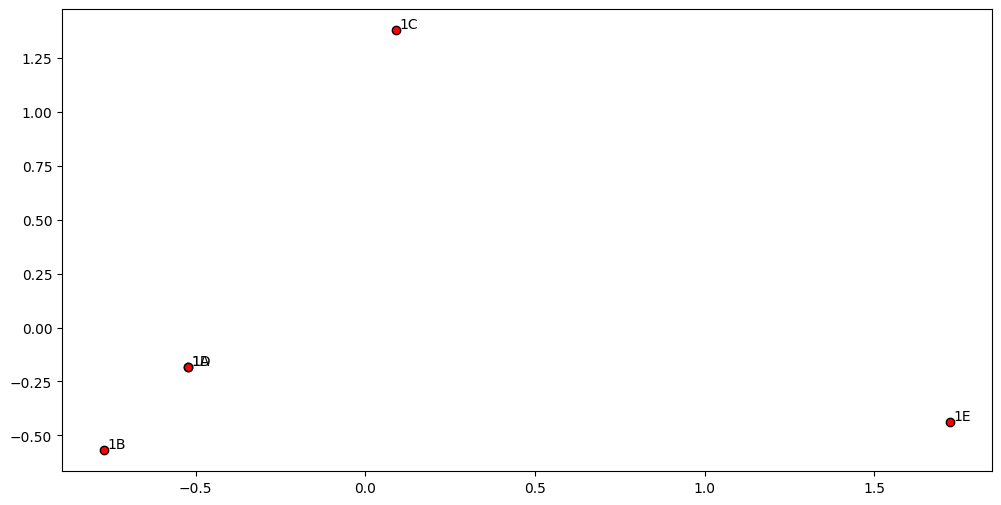

In [18]:
twodim = PCA().fit_transform(X2.toarray())[:,:2]
plt.figure(figsize=(12,6))
plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(pic_sentence_labels, twodim):
    plt.text(x+0.01, y+0.01, word)
plt.show()

In [19]:
cv = CountVectorizer()
X3 = cv.fit_transform(processed_pic11013+processed_pic16+processed_pic2+processed_pic31782)
cv.get_feature_names_out()

array(['alike', 'background', 'blue', 'boat', 'body', 'bowl', 'building',
       'cabin', 'canvas', 'child', 'climb', 'cover', 'dance', 'dress',
       'entry', 'fingerpaint', 'fog', 'girl', 'grass', 'group', 'hand',
       'hang', 'harbor', 'hawaiian', 'hill', 'large', 'lean', 'like',
       'little', 'look', 'man', 'mist', 'moor', 'mountain', 'outside',
       'paint', 'painting', 'participate', 'people', 'perform', 'pigtail',
       'pilot', 'pink', 'play', 'playhouse', 'rail', 'rainbow', 'ride',
       'roll', 'set', 'shirt', 'short', 'sit', 'skit', 'small', 'stage',
       'stair', 'water', 'way', 'white', 'woman', 'wooden', 'young'],
      dtype=object)

<Axes: >

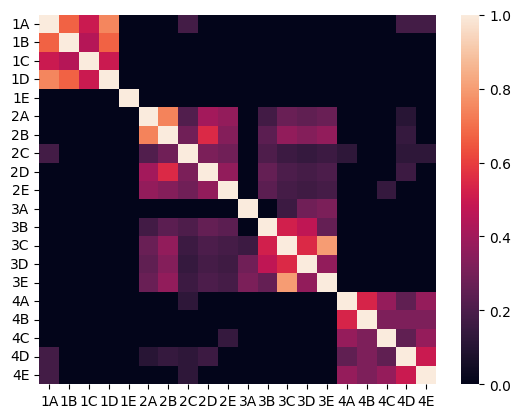

In [20]:
sns.heatmap(cosine_similarity(X3), xticklabels=pic_sentence_labels, yticklabels=pic_sentence_labels)

In [21]:
from sklearn.cluster import KMeans
cls = KMeans(n_clusters=4)
cls.fit_predict(X3)

# to get cluster labels for the dataset used while
# training the model (used for models that do not
# support prediction on new dataset).
cls.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
      dtype=int32)

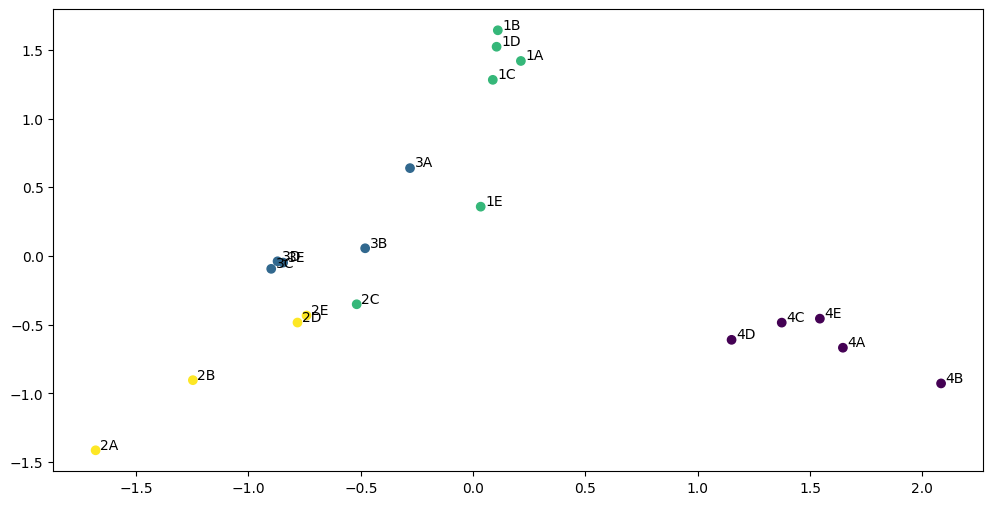

In [22]:
twodim = PCA().fit_transform(X3.toarray())[:,:2]
plt.figure(figsize=(12,6))
plt.scatter(twodim[:,0], twodim[:,1], c=cls.labels_)
for word, (x,y) in zip(pic_sentence_labels, twodim):
    plt.text(x+0.02, y+0.01, word)
plt.show()

# TF-IDF

In [23]:
for n in range(1,5):
  print(f"word appearing in {n} of 4 documents, will have idf = np.log(4/{n})+1 =",
        np.log(4/n)+1)

word appearing in 1 of 4 documents, will have idf = np.log(4/1)+1 = 2.386294361119891
word appearing in 2 of 4 documents, will have idf = np.log(4/2)+1 = 1.6931471805599454
word appearing in 3 of 4 documents, will have idf = np.log(4/3)+1 = 1.2876820724517808
word appearing in 4 of 4 documents, will have idf = np.log(4/4)+1 = 1.0


In [24]:
vectorizer = TfidfVectorizer(smooth_idf=False, norm=None)
tfidf_matrix = vectorizer.fit_transform(processed_pic11013[:4])

In [25]:
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , 0.        , 1.28768207,
         0.        , 1.        , 2.38629436, 1.        ],
        [2.38629436, 0.        , 2.38629436, 0.        , 1.28768207,
         0.        , 1.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 2.38629436, 0.        ,
         2.38629436, 1.        , 0.        , 1.        ],
        [0.        , 2.38629436, 0.        , 0.        , 1.28768207,
         0.        , 1.        , 0.        , 1.        ]])

In [26]:
vectorizer.idf_

array([2.38629436, 2.38629436, 2.38629436, 2.38629436, 1.28768207,
       2.38629436, 1.        , 2.38629436, 1.        ])

In [27]:
dictionary = vectorizer.get_feature_names_out()
dictionary

array(['alike', 'group', 'look', 'participate', 'perform', 'skit',
       'stage', 'white', 'woman'], dtype=object)

In [28]:
norm_vectorizer = TfidfVectorizer(smooth_idf=False)
norm_tfidf_matrix = norm_vectorizer.fit_transform(processed_pic11013[:4])

In [29]:
norm_tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.4210602 ,
         0.        , 0.3269908 , 0.78029631, 0.3269908 ],
        [0.61517703, 0.        , 0.61517703, 0.        , 0.33195923,
         0.        , 0.25779595, 0.        , 0.25779595],
        [0.        , 0.        , 0.        , 0.65215851, 0.        ,
         0.65215851, 0.2732934 , 0.        , 0.2732934 ],
        [0.        , 0.78029631, 0.        , 0.        , 0.4210602 ,
         0.        , 0.3269908 , 0.        , 0.3269908 ]])

In [30]:
norm_vectorizer.idf_ == vectorizer.idf_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [31]:
print(np.argmin(vectorizer.idf_))
print(dictionary[np.argmin(vectorizer.idf_)])

6
stage


In [32]:
print(np.argmax(vectorizer.idf_))
print(dictionary[np.argmax(vectorizer.idf_)])

0
alike


In [33]:
vectorizer = TfidfVectorizer(smooth_idf=False)
tfidf_matrix = vectorizer.fit_transform(processed_pic11013+processed_pic16+processed_pic2+processed_pic31782)
vectorizer.get_feature_names_out()

array(['alike', 'background', 'blue', 'boat', 'body', 'bowl', 'building',
       'cabin', 'canvas', 'child', 'climb', 'cover', 'dance', 'dress',
       'entry', 'fingerpaint', 'fog', 'girl', 'grass', 'group', 'hand',
       'hang', 'harbor', 'hawaiian', 'hill', 'large', 'lean', 'like',
       'little', 'look', 'man', 'mist', 'moor', 'mountain', 'outside',
       'paint', 'painting', 'participate', 'people', 'perform', 'pigtail',
       'pilot', 'pink', 'play', 'playhouse', 'rail', 'rainbow', 'ride',
       'roll', 'set', 'shirt', 'short', 'sit', 'skit', 'small', 'stage',
       'stair', 'water', 'way', 'white', 'woman', 'wooden', 'young'],
      dtype=object)

In [34]:
vectorizer.idf_

array([3.99573227, 2.89711998, 3.30258509, 2.38629436, 3.99573227,
       3.99573227, 3.99573227, 3.99573227, 3.99573227, 3.99573227,
       2.89711998, 3.99573227, 3.99573227, 3.30258509, 3.99573227,
       3.99573227, 2.89711998, 1.7985077 , 3.30258509, 3.99573227,
       3.99573227, 3.99573227, 3.99573227, 3.99573227, 3.30258509,
       3.99573227, 3.30258509, 3.99573227, 2.38629436, 3.99573227,
       2.38629436, 3.99573227, 3.99573227, 3.30258509, 3.99573227,
       2.89711998, 3.99573227, 3.99573227, 3.99573227, 2.89711998,
       3.30258509, 3.99573227, 3.30258509, 3.99573227, 3.30258509,
       3.99573227, 2.60943791, 3.99573227, 3.99573227, 3.99573227,
       3.99573227, 3.99573227, 2.60943791, 3.99573227, 3.30258509,
       2.60943791, 3.30258509, 3.99573227, 3.99573227, 2.60943791,
       2.60943791, 2.89711998, 3.30258509])

In [35]:
print(np.argmin(vectorizer.idf_))
print(vectorizer.get_feature_names_out()[np.argmin(vectorizer.idf_)])

17
girl


In [36]:
print(np.argmax(vectorizer.idf_))
print(vectorizer.get_feature_names_out()[np.argmax(vectorizer.idf_)])

0
alike


In [37]:
tfidf_matrix

<20x63 sparse matrix of type '<class 'numpy.float64'>'
	with 122 stored elements in Compressed Sparse Row format>

<Axes: >

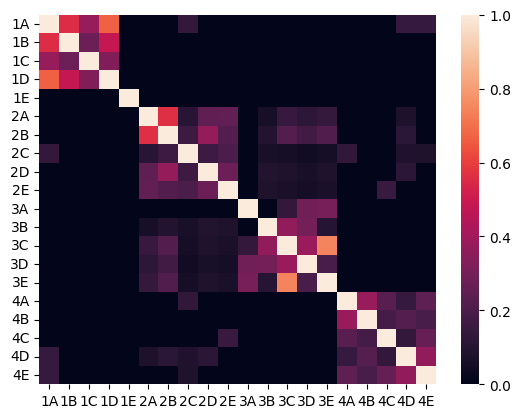

In [38]:
import seaborn as sns
sns.heatmap(cosine_similarity(tfidf_matrix), xticklabels=pic_sentence_labels, yticklabels=pic_sentence_labels )

In [39]:
cls = KMeans(n_clusters=4)
cls.fit_predict(tfidf_matrix)

# to get cluster labels for the dataset used while
# training the model (used for models that do not
# support prediction on new dataset).
cls.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 0, 0, 0, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3],
      dtype=int32)

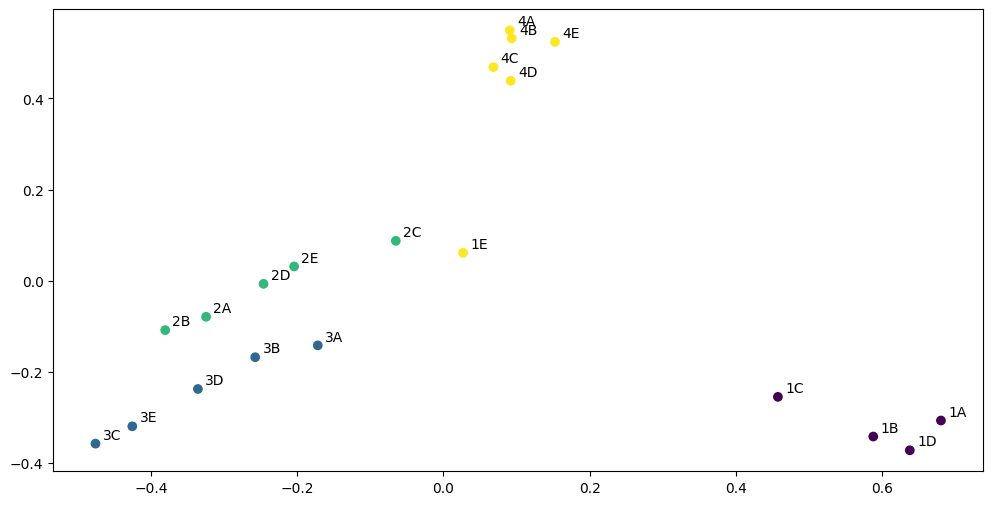

In [40]:
twodim = PCA().fit_transform(np.array(tfidf_matrix.todense()))[:,:2]
plt.figure(figsize=(12,6))
plt.scatter(twodim[:,0], twodim[:,1], c=cls.labels_)
for word, (x,y) in zip(pic_sentence_labels, twodim):
    plt.text(x+0.01, y+0.01, word)
plt.show()

# Word Embeddings

In [41]:
medium_example = pd.DataFrame(np.array([[0.96,0.92,0.08,0.67],[0.98,0.07,0.98,0.71],[0.05,0.90,0.10,0.56],[0.56,0.09,0.91,0.11],[0.95,0.85,0.15,0.42]]),
                                       columns=['Royalty', 'Masculinity', 'Femininity', 'Age'], index=['KING', 'QUEEN', 'MAN', 'GIRL', 'PRINCE'])

In [42]:
medium_example

,Royalty,Masculinity,Femininity,Age
KING,0.96,0.92,0.08,0.67
QUEEN,0.98,0.07,0.98,0.71
MAN,0.05,0.90,0.10,0.56
GIRL,0.56,0.09,0.91,0.11
PRINCE,0.95,0.85,0.15,0.42


(0.0, 1.0)

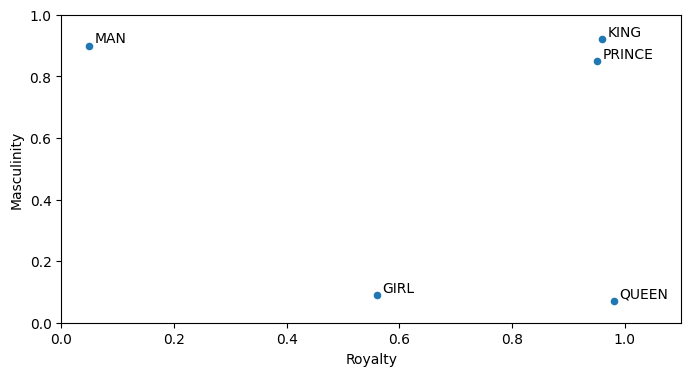

In [43]:
ax1 = medium_example.plot.scatter(x='Royalty', y='Masculinity', figsize=(8,4))
for k, v in medium_example[["Royalty", "Masculinity"]].iterrows():
    ax1.annotate(k, v+0.01)
ax1.set_xlim(0,1.1)
ax1.set_ylim(0,1)


#ax2 = medium_example.plot.scatter(x='Femininity', y='Age')
#for k, v in medium_example[["Femininity", "Age"]].iterrows():
#    ax2.annotate(k, v)


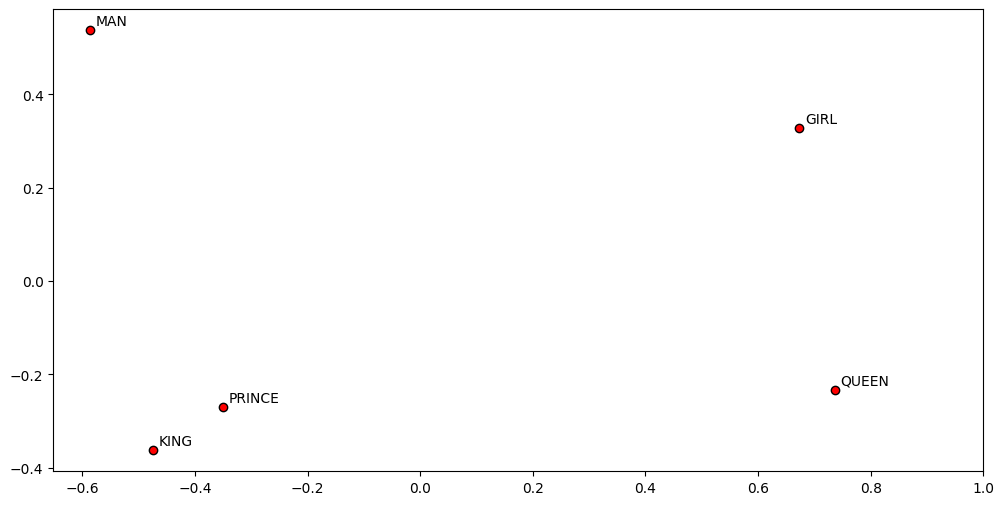

In [44]:
word_vectors = np.array(medium_example)
twodim = PCA().fit_transform(word_vectors)[:,:2]
plt.figure(figsize=(12,6))
plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(medium_example.index, twodim):
    plt.text(x+0.01, y+0.01, word)
plt.xlim(right=1.0)
plt.show()

In [45]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.key_to_index), sample)
        else:
            words = [ word for word in model.vocab ]

    word_vectors = np.array([model(w).vector for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(12,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.5, y+0.5, word)

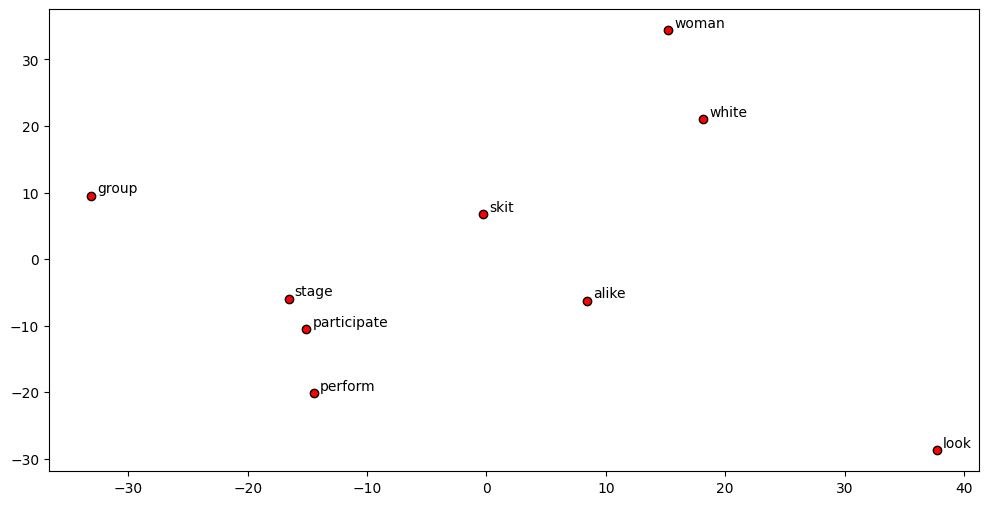

In [46]:
display_pca_scatterplot(nlp,words=dictionary.tolist())

In [47]:
example_sentences = ["President Obama visited Beijing last week", "The first African-American US President arrived at Peking a few days ago",
             "Hamilton beats Button and wins the game", "Button beats Hamilton and wins the game"]

In [48]:
Jaccard(example_sentences[0], example_sentences[1], True)

{'last', 'President', 'Beijing', 'week', 'visited', 'Obama'}
{'a', 'President', 'at', 'ago', 'Peking', 'African-American', 'days', 'arrived', 'US', 'The', 'first', 'few'}
overlap:  {'President'}
Total words:  17


0.058823529411764705

In [49]:
Jaccard(example_sentences[2], example_sentences[3], True)

{'beats', 'the', 'wins', 'game', 'Hamilton', 'and', 'Button'}
{'beats', 'the', 'wins', 'game', 'Hamilton', 'and', 'Button'}
overlap:  {'beats', 'the', 'wins', 'game', 'Hamilton', 'and', 'Button'}
Total words:  7


1.0

In [50]:
vec = TfidfVectorizer(smooth_idf=False,stop_words="english")
tfidf_mat = vec.fit_transform(example_sentences)

In [51]:
cosine_similarity(tfidf_mat)

array([[1.        , 0.09302469, 0.        , 0.        ],
       [0.09302469, 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 1.        ],
       [0.        , 0.        , 1.        , 1.        ]])

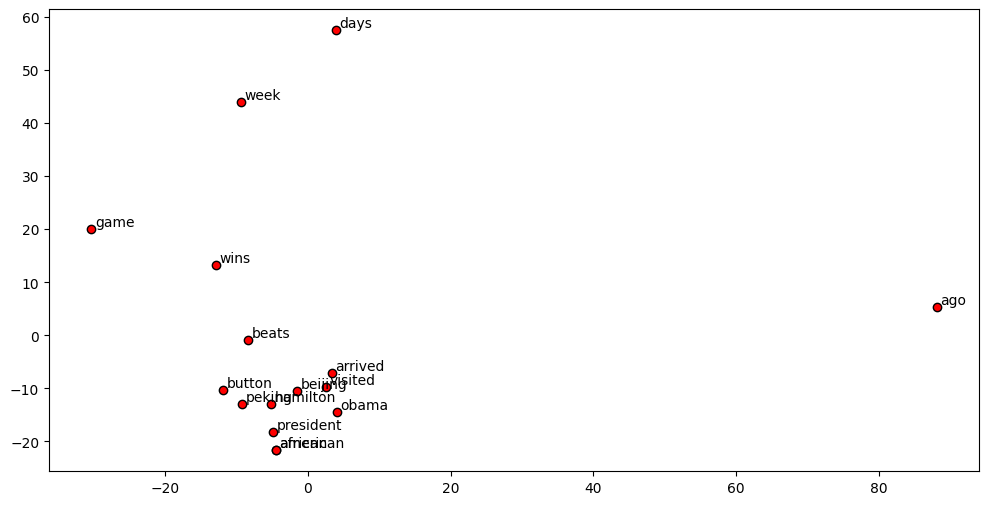

In [52]:
display_pca_scatterplot(nlp, vec.get_feature_names_out().tolist())

In [53]:
cosine_similarity([nlp("king").vector], [nlp("girl").vector])

array([[0.22843453]], dtype=float32)

In [54]:
nlp("king").similarity(nlp("girl"))

0.228434522148802

In [55]:
nlp11013 = []
nlp2 = []
nlp16 = []
nlp31782 = []
for i in range(5):
  nlp11013.append(nlp(pic11013[i]).vector)
  nlp2.append(nlp(pic2[i]).vector)
  nlp16.append(nlp(pic16[i]).vector)
  nlp31782.append(nlp(pic31782[i]).vector)

<Axes: >

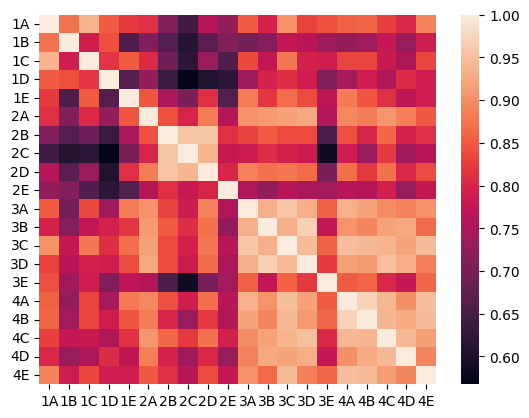

In [56]:
sns.heatmap(cosine_similarity(nlp11013+nlp2+nlp16+nlp31782), xticklabels=pic_sentence_labels,yticklabels=pic_sentence_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


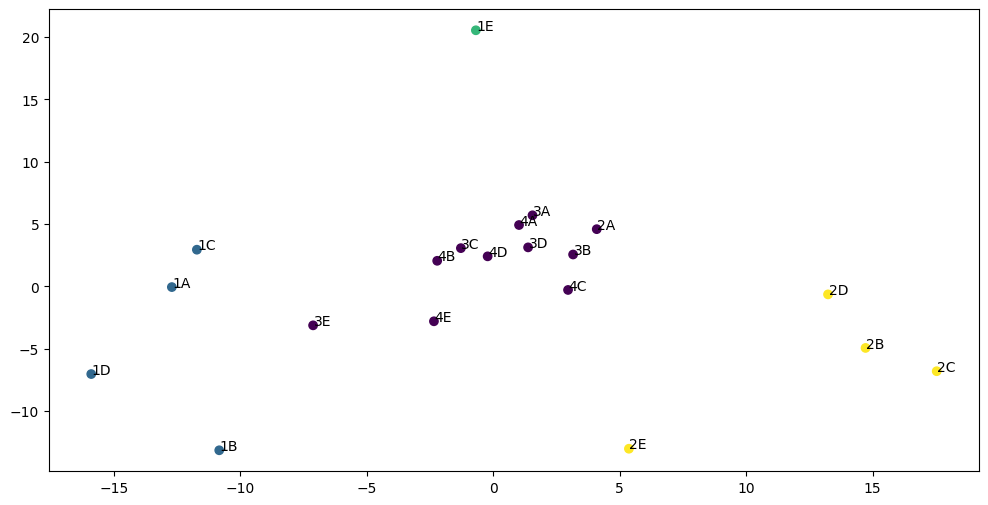

In [57]:
cls = KMeans(n_clusters=4)
cls.fit_predict(nlp11013+nlp2+nlp16+nlp31782)

# to get cluster labels for the dataset used while
# training the model (used for models that do not
# support prediction on new dataset).
cls.labels_

twodim = PCA().fit_transform(nlp11013+nlp2+nlp16+nlp31782)[:,:2]
plt.figure(figsize=(12,6))
plt.scatter(twodim[:,0], twodim[:,1], c=cls.labels_)
for word, (x,y) in zip(pic_sentence_labels, twodim):
    plt.text(x+0.02, y+0.01, word)
plt.show()

In [58]:
nlp(pic11013[4])

People in a dance

In [68]:
(nlp(pic11013[4]).vector == np.mean([nlp("People").vector,nlp("in").vector,nlp("a").vector,nlp("dance").vector],axis=0)).all()

True